In [199]:
!pip install catboost

   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.5/102.4 MB 1.7 MB/s eta 0:01:02
   ---------------------------------------- 0.8/102.4 MB 1.3 MB/s eta 0:01:20
   ---------------------------------------- 0.8/102.4 MB 1.3 MB/s eta 0:01:20
    --------------------------------------- 1.3/102.4 MB 1.3 MB/s eta 0:01:17
    --------------------------------------- 1.8/102.4 MB 1.6 MB/s eta 0:01:04
    --------------------------------------- 2.4/102.4 MB 1.7 MB/s eta 0:00:59
   - -------------------------------------- 2.9/102.4 MB 1.9 MB/s eta 0:00:54
   - -------------------------------------- 3.4/102.4 MB 2.0 MB/s eta 0:00:51
   - -------------------------------------- 3.9/102.4 MB 2.1 MB/s eta 0:00:48
   - -------------------------------------- 4.7/102.4 MB 2.2 MB/s eta 0:00:45
   -- -

In [1]:
import pandas as pd
import numpy as np

### Read the prepared training and testing data into dataframes

In [266]:
training_data = pd.read_csv("refined_training_data.csv").set_index("id")

In [267]:
training_data = training_data.drop(columns = {"SMILES"})

In [268]:
training_data.shape

(2634, 135)

In [269]:
sanity_check = training_data["Tm"]
sanity_check.head(4)

id
1    427.55
3    213.15
5    533.35
6    542.65
Name: Tm, dtype: float64

In [270]:
testing_data = pd.read_csv("refined_testing_data.csv").set_index("id")

In [271]:
testing_data = testing_data.drop(columns = {"SMILES"})

In [272]:
testing_data.shape

(666, 134)

#### Split the training data into features X, and target y

In [273]:
X = training_data.drop(columns = "Tm")
y = training_data["Tm"]

In [274]:
X.shape

(2634, 134)

In [275]:
y.shape

(2634,)

#### Partition the training data into training and validation sets

In [276]:
from sklearn.model_selection import train_test_split

In [277]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42
)

In [278]:
X_train.shape

(2107, 134)

In [279]:
y_train.shape

(2107,)

In [280]:
X_val.shape

(527, 134)

In [281]:
y_val.shape

(527,)

## Model construction

### XBG pipeline

In [282]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
from sklearn.metrics import mean_absolute_error

In [283]:
#Basic pipeline containing xgb model

xgb_pipeline = Pipeline([
    ("xgb", XGBRegressor(
        objective = "reg:squarederror",
        tree_method = "hist",
        eval_metric = "mae",
        random_state = 42
    ))
])

In [284]:
#Refined paramters for xgb model

xgb_param_dist = {
    "xgb__n_estimators": randint(600, 1201),
    "xgb__max_depth": randint(2, 6),
    "xgb__min_child_weight": randint(1, 5),
    "xgb__learning_rate": uniform(0.01, 0.03),     # 0.01–0.045
    "xgb__subsample": uniform(0.6, 0.3),           # 0.6–0.9
    "xgb__colsample_bytree": uniform(0.2, 0.3),    # 0.2 - 0.5
    "xgb__reg_alpha": uniform(0.03, 0.09),         # 0.03–0.12
    "xgb__reg_lambda": uniform(1.0, 5.0),          # 1.0–6.0
    "xgb__gamma": uniform(0.0, 0.06),              # 0.0–0.06
}

In [285]:
#Randomized search cross validation pipeline

xgb_search = RandomizedSearchCV(
    estimator = xgb_pipeline,
    param_distributions = xgb_param_dist,
    n_iter = 50,
    cv = 5,
    scoring = "neg_mean_absolute_error",
    n_jobs = -1,
    random_state = 42,
    verbose = 1,
    refit = True,
    error_score = "raise"
)

#### Fit the model on the training data, and print best parameters and training MAE

In [286]:
xgb_search.fit(X_train, y_train)

print("Best params:", xgb_search.best_params_)
print("Best CV MAE:", xgb_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'xgb__colsample_bytree': np.float64(0.4808464322482343), 'xgb__gamma': np.float64(0.04176178780049838), 'xgb__learning_rate': np.float64(0.027101835102680952), 'xgb__max_depth': 5, 'xgb__min_child_weight': 2, 'xgb__n_estimators': 887, 'xgb__reg_alpha': np.float64(0.09040291651416454), 'xgb__reg_lambda': np.float64(2.7932339064808196), 'xgb__subsample': np.float64(0.6762490947209217)}
Best CV MAE: -28.881919807513874


#### Model evaluation on validation set

In [287]:
best_model_xgb = xgb_search.best_estimator_
y_pred_xgb = best_model_xgb.predict(X_val)
print("Validation MAE:", mean_absolute_error(y_val, y_pred_xgb))

Validation MAE: 27.330190806090265


#### Plot predicted and true values for validation examples

In [288]:
from sklearn.metrics import r2_score

In [289]:
r2_xgb = r2_score(y_val, y_pred_xgb)

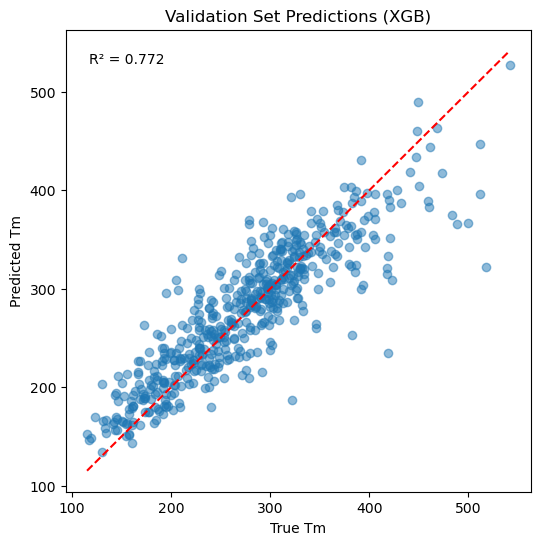

In [290]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_xgb, alpha=0.5)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         'r--')

plt.text(
    0.05, 0.95,
    f"R² = {r2_xgb:.3f}",
    transform = plt.gca().transAxes,
va = "top"
)

plt.xlabel("True Tm")
plt.ylabel("Predicted Tm")
plt.title("Validation Set Predictions (XGB)")
plt.show()

#### Get feaure importance from the model

In [291]:
xgb_best_feat = XGBRegressor(
    colsample_bytree=0.3399722324732881,
    gamma=0.044154276791760136,
    learning_rate=0.0404438428640065,
    max_depth=5,
    min_child_weight=1,
    n_estimators=1147,
    reg_alpha=0.08786330072528278,
    reg_lambda=4.519730675692547,
    subsample=0.8731872010620911,
    objective="reg:squarederror",  
    n_jobs=-1,
    tree_method="hist",            
)

In [292]:
from sklearn.feature_selection import SelectFromModel

xgb_best_feat.fit(X_train, y_train)

importances = xgb_best_feat.feature_importances_

feature_importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

In [293]:
feature_importance_df.head(10)

,feature,importance
60,FP_1380,0.137806
121,RingCount,0.080335
55,FP_1267,0.040518
119,HBD,0.033161
75,FP_1750,0.026786
49,FP_1143,0.024814
83,FP_1928,0.023341
118,TPSA,0.019142
124,BertzCT,0.017855
1,FP_13,0.017154


### CatBoost pipeline

In [294]:
from catboost import CatBoostRegressor

In [295]:
#Basic cat boost pipeline

cat_pipeline = Pipeline([
    ("cat", CatBoostRegressor(
        loss_function="MAE",
        eval_metric="MAE",
        bootstrap_type="Bernoulli",   
        random_seed=42,
        allow_writing_files=False,
        verbose=False                 
    ))
])

In [296]:
#Refined paramter grid

cat_param_dist = {
    "cat__iterations": randint(600, 2001),          
    "cat__depth": randint(4, 10),                   
    "cat__learning_rate": uniform(0.01, 0.07),     
    "cat__l2_leaf_reg": uniform(1.0, 9.0),          
    "cat__subsample": uniform(0.7, 0.3),            
    "cat__rsm": uniform(0.4, 0.4),                  
}

In [297]:
#Randomized search cross validation pipeline

cat_search = RandomizedSearchCV(
    estimator = cat_pipeline,
    param_distributions = cat_param_dist,
    n_iter = 50,                      
    cv = 3,
    scoring = "neg_mean_absolute_error",
    n_jobs = -1,
    random_state = 42,
    verbose = 1,
    refit = True,
    error_score = "raise"
)

#### Fit the model on the training data, and print best parameters and training MAE

In [298]:
cat_search.fit(X_train, y_train)

print("Best params (CV):", cat_search.best_params_)
print("Best CV MAE:", -cat_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best params (CV): {'cat__depth': 8, 'cat__iterations': 1347, 'cat__l2_leaf_reg': np.float64(1.2075618253727418), 'cat__learning_rate': np.float64(0.046734226218087246), 'cat__rsm': np.float64(0.5599443886861022), 'cat__subsample': np.float64(0.7139996989640846)}
Best CV MAE: 28.79559293246629


#### Model evaluation on validation set

In [299]:
best_model_cat = cat_search.best_estimator_
y_pred_cat = best_model_cat.predict(X_val)
print("Validation MAE:", mean_absolute_error(y_val, y_pred_cat))

Validation MAE: 26.943618945456812


#### Plot predicted and true values for validation examples

In [300]:
r2_cat = r2_score(y_val, y_pred_cat)

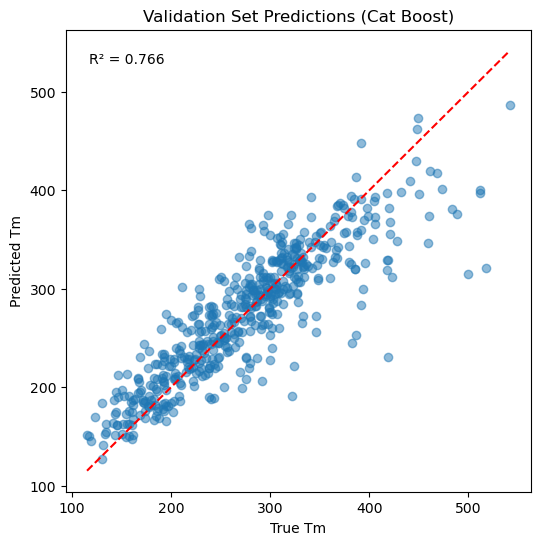

In [301]:
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_cat, alpha=0.5)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         'r--')

plt.text(
    0.05, 0.95,
    f"R² = {r2_cat:.3f}",
    transform = plt.gca().transAxes,
va = "top"
)

plt.xlabel("True Tm")
plt.ylabel("Predicted Tm")
plt.title("Validation Set Predictions (Cat Boost)")
plt.show()

### SVR pipeline

In [302]:
# SVR model requires standarization of continoues training features, will include standard scaler in the pipeline
# All features, apart from the fingerprints, are continoues, and require scaling

In [303]:
desc_cols = [c for c in X_train.columns if not c.startswith("FP")]
fp_cols = [c for c in X_train.columns if c.startswith("FP")]

In [304]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from numpy import logspace
from sklearn.compose import ColumnTransformer

In [305]:
# SVR pipeline with feature scaling included

svr_pipeline = Pipeline([
    (
        "prep",
        ColumnTransformer(
            transformers = [
                ("scale", StandardScaler(), desc_cols)
            ],
            remainder = "passthrough"
        )
    ),
    ("svr", SVR(kernel="rbf"))
])

In [306]:
# refined parameter grid for svr model

svr_param_dist = {
    "svr__kernel": ["rbf"],

    "svr__C": [200, 300, 500, 800],
    "svr__gamma": ["scale", "auto", 0.0005, 0.001, 0.005, 0.01],
    "svr__epsilon": [0.5, 1, 2, 3, 5, 7],

    "svr__shrinking": [True, False],
    "svr__tol": uniform(0.0001, 0.0009),
}

In [307]:
#Randomized search cross validation pipeline

svr_search = RandomizedSearchCV(
    estimator=svr_pipeline,
    param_distributions=svr_param_dist,
    n_iter=100,                     
    cv=5,
    scoring="neg_mean_absolute_error",
    random_state=42,
    n_jobs=-1
)

#### Fit the model on the training data, and print best parameters and training MAE

In [308]:
svr_search.fit(X_train, y_train)

print("Best params (CV):", svr_search.best_params_)
print("Best CV MAE:", -svr_search.best_score_)

Best params (CV): {'svr__C': 200, 'svr__epsilon': 1, 'svr__gamma': 0.01, 'svr__kernel': 'rbf', 'svr__shrinking': False, 'svr__tol': np.float64(0.00033214746494364004)}
Best CV MAE: 29.238654714655365


#### Model evaluation on validation set

In [309]:
best_model_svr = svr_search.best_estimator_
y_pred_svr = best_model_svr.predict(X_val)
print("Validation MAE:", mean_absolute_error(y_val, y_pred_svr))

Validation MAE: 26.58448044061303


#### Plot predicted and true values for validation examples

In [310]:
r2_svr = r2_score(y_val, y_pred_svr)

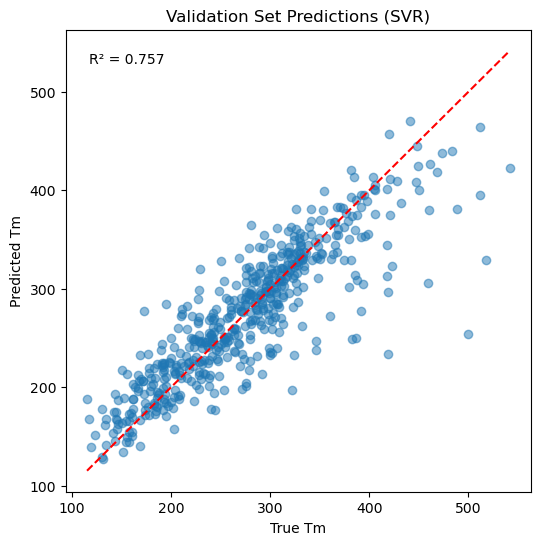

In [311]:
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_svr, alpha=0.5)

plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         'r--')

plt.text(
    0.05, 0.95,
    f"R² = {r2_svr:.3f}",
    transform = plt.gca().transAxes,
va = "top"
)
plt.xlabel("True Tm")
plt.ylabel("Predicted Tm")
plt.title("Validation Set Predictions (SVR)")
plt.show()

### Combine the validation set predictions for all three models onto one set of axes

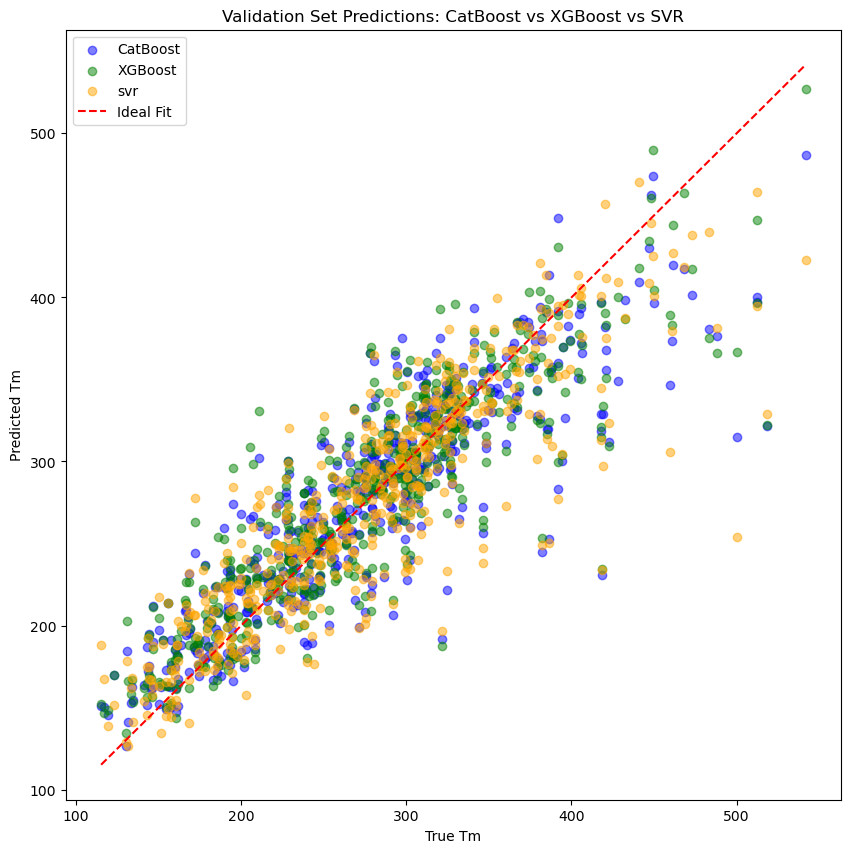

In [312]:
plt.figure(figsize=(10,10)) 

# CatBoost predictions (blue) 
plt.scatter(y_val, y_pred_cat, alpha=0.5, color="blue", label="CatBoost") 

# XGBoost predictions (green) 
plt.scatter(y_val, y_pred_xgb, alpha=0.5, color="green", label="XGBoost") 

# SVR predictions (orange)
plt.scatter(y_val, y_pred_svr, alpha=0.5, color="orange", label="svr") 

# Identity line 
plt.plot([y_val.min(), y_val.max()], 
         [y_val.min(), y_val.max()], 
         'r--', label="Ideal Fit") 

plt.xlabel("True Tm") 
plt.ylabel("Predicted Tm") 
plt.title("Validation Set Predictions: CatBoost vs XGBoost vs SVR") 
plt.legend() 
plt.show()

In [313]:
# All three models perform reasonably well, with MAE on the validation set around 26 and a bit above. 

# The validtion plots show the models do well with most examples, but lose accuracy for the higher melting compounds, 


### Stack the three generated models into a single ensemble model

In [314]:
from sklearn.base import clone
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

In [315]:
xgb_best = clone(xgb_search.best_estimator_)
cat_best = clone(cat_search.best_estimator_)
svr_best = clone(svr_search.best_estimator_)

In [316]:
# Pipeline for combining the three models

stack = StackingRegressor(
    estimators=[
        ("xgb", xgb_best),   
        ("cat", cat_best),  
        ("svr", svr_best),   
    ],
    final_estimator=RidgeCV(alphas=[0.1, 0.3, 1.0, 3.0, 10.0]),
    cv=5,
    passthrough=False,
    n_jobs=-1
)

#### Fit the model on the training data, and print best parameters and training MAE

In [317]:
stack.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('xgb',
                               Pipeline(steps=[('xgb',
                                                XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=np.float64(0.4808464322482343),
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric='mae',
                                                             feature_types=None,
                                                             feature_weights=None,
                                                             gamma=np.floa...
                                                                                  'Group '
                                                                                  '80',
                                                                                  'Group '
                                                                                  '123',
                                                                                  'Group '
                                                                                  '126',
                                                                                  'Group '
                                                                                  '128',
                                                                                  'Group '
                                                                                  '130',
                                                                                  'Group '
                                                                                  '168',
                                                                                  'Group '
                                                                                  '169',
                                                                                  'Group '
                                                                                  '180',
                                                                                  'Group '
                                                                                  '221',
                                                                                  'Group '
                                                                                  '228',
                                                                                  'Group '
                                                                                  '324',
                                                                                  'Group '
                                                                                  '325',
                                                                                  'Group '
                                                                                  '326',
                                                                                  'Group '
                                                                                  '328', ...])])),
                                               ('svr',
                                                SVR(C=200, epsilon=1,
                                                    gamma=0.01, shrinking=False,
                                                    tol=np.float64(

#### Stacked model evaluation on validation set

In [318]:
y_pred_stack = stack.predict(X_val) 
print("Val MAE:", mean_absolute_error(y_val, y_pred_stack))

Val MAE: 26.359012825605774


#### Weighted parameters for final stacked model

In [319]:
final = stack.final_estimator_
print(getattr(final, "coef_", None), getattr(final, "intercept_", None))

[0.70348148 0.1696497  0.16193389] -8.219832519388433


In [320]:
# The xgb model contributes the most to the stack, which makes sense as it had the lowest training MAE. 
# The cat boost model has a negligible contribution to the stack

#### Plot predicted and true values for validation examples for stacked model

In [321]:
r2_stack = r2_score(y_val, y_pred_stack)

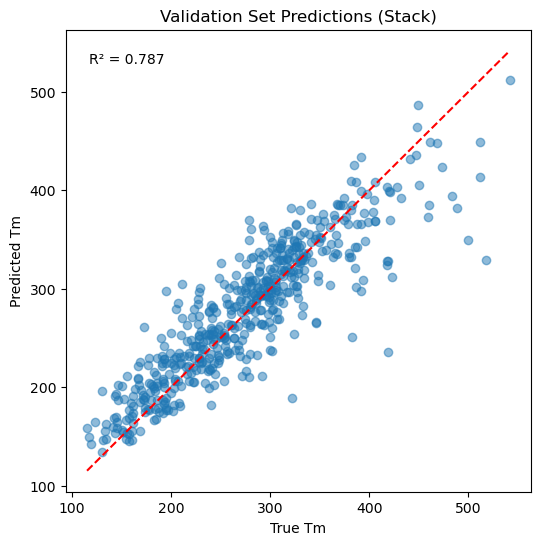

In [322]:
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_stack, alpha=0.5)

plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         'r--')

plt.text(
    0.05, 0.95,
    f"R² = {r2_stack:.3f}",
    transform = plt.gca().transAxes,
va = "top"
)
plt.xlabel("True Tm")
plt.ylabel("Predicted Tm")
plt.title("Validation Set Predictions (Stack)")
plt.show()

In [323]:
# The stackd model seems to have the same issue as the three standalone models (which makes sense), 
# of not doing great for the higher melting compounds

#### Run stacked model on the testing examples

In [121]:
y_pred_test = stack.predict(testing_data) 

In [125]:
testing_data["Tm"] = y_pred_test

In [127]:
submission = testing_data["Tm"]

In [129]:
submission.to_csv("stacked_model_pred.csv", header = True)

### Neural network for MP prediction

In [324]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

In [456]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[desc_cols] = scaler.fit_transform(X_train[desc_cols])

X_val_scaled = X_val.copy()
X_val_scaled[desc_cols] = scaler.transform(X_val[desc_cols])

X_test_scaled = testing_data.copy()
X_test_scaled[desc_cols] = scaler.transform(testing_data[desc_cols])


In [448]:
def build_model(input_dim, lr=1e-3):
    reg = regularizers.l2(2e-5)

    inp = keras.Input(shape=(input_dim,))
    x = layers.GaussianNoise(0.01)(inp) 
    x = layers.BatchNormalization()(x)

    for units in [256, 128]:
        x = layers.Dense(units, kernel_regularizer=reg)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Dropout(0.25)(x)       

    out = layers.Dense(1)(x)

    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mae",
        metrics=["mae"]
    )
    return model

In [449]:
model = build_model(input_dim=X_train_scaled.shape[1], lr=1e-3)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
    monitor="val_mae",
    factor=0.8,
    patience=10,
    min_lr=1e-5,
    verbose=1
    ),
    
    keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=30,
    restore_best_weights=True,
    verbose=1
    )
]

In [450]:
fit = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=600,
    batch_size=64,
    verbose=1,
    callbacks=callbacks
    )

Epoch 1/600
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 276.5037 - mae: 276.4967 - val_loss: 274.1534 - val_mae: 274.1464 - learning_rate: 0.0010
Epoch 2/600
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 274.2693 - mae: 274.2622 - val_loss: 272.6832 - val_mae: 272.6761 - learning_rate: 0.0010
Epoch 3/600
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 271.9011 - mae: 271.8940 - val_loss: 270.5890 - val_mae: 270.5818 - learning_rate: 0.0010
Epoch 4/600
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 269.2395 - mae: 269.2324 - val_loss: 267.3936 - val_mae: 267.3864 - learning_rate: 0.0010
Epoch 5/600
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 266.0545 - mae: 266.0473 - val_loss: 262.8673 - val_mae: 262.8600 - learning_rate: 0.0010
Epoch 6/600
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 262.2866 - mae: 262.2793 - val_loss: 257.2111 - val_mae: 257.2037 - learning_rate: 0.0010
Epoch 7/600
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 257.9001 - mae: 257.8926 - val_loss: 249.8771 -

In [451]:
def plot_loss_mae(history):
    hist = history.history if hasattr(history, "history") else history
    epochs = range(1, len(hist['loss']) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    
    axs[0].plot(epochs, hist['loss'], label='Training loss')
    if 'val_loss' in hist:
        axs[0].plot(epochs, hist['val_loss'], label='Validation loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    
    if 'mae' in hist:
        axs[1].plot(epochs, hist['mae'], label='Training MAE')
    if 'val_mae' in hist:
        axs[1].plot(epochs, hist['val_mae'], label='Validation MAE')
    axs[1].set_title('Mean Absolute Error')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('MAE')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

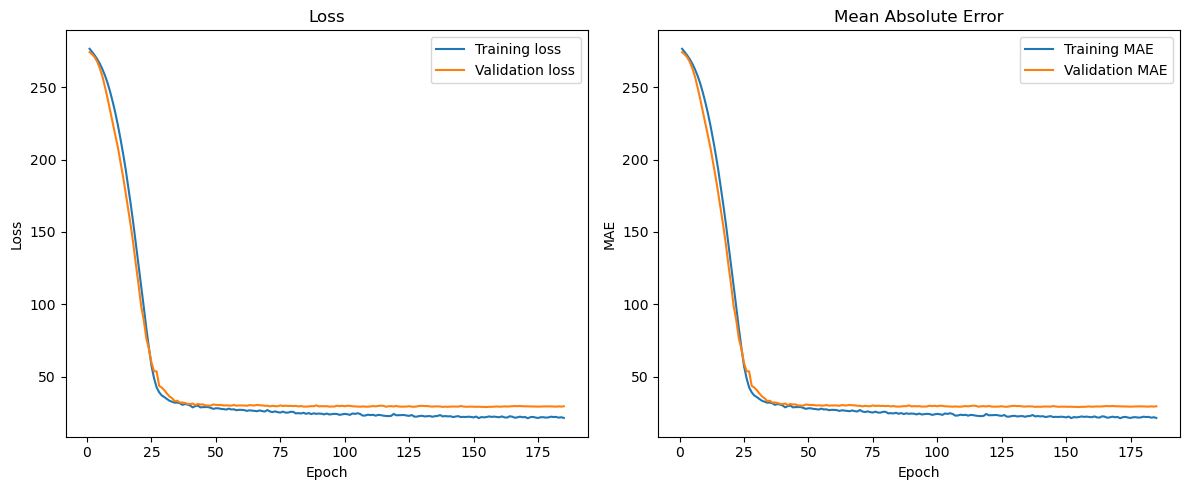

In [452]:
plot_loss_mae(fit)

In [453]:
y_pred_nn = model.predict(X_val_scaled) 
print("Val MAE:", mean_absolute_error(y_val, y_pred_nn))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Val MAE: 29.0425883029308


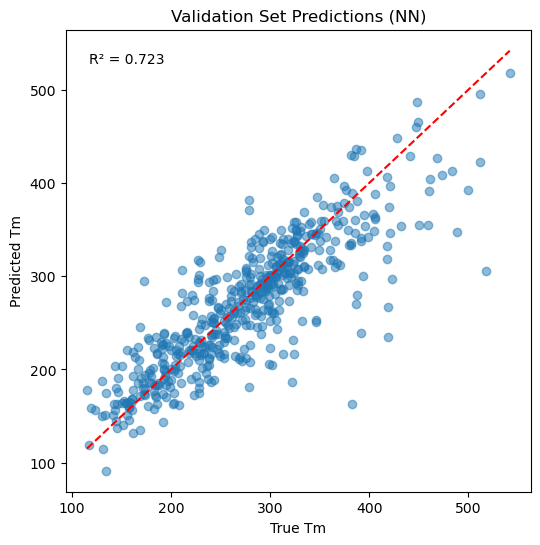

In [462]:
r2_nn = r2_score(y_val, y_pred_nn)

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_nn, alpha=0.5)

plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         'r--')

plt.text(
    0.05, 0.95,
    f"R² = {r2_nn:.3f}",
    transform = plt.gca().transAxes,
va = "top"
)
plt.xlabel("True Tm")
plt.ylabel("Predicted Tm")
plt.title("Validation Set Predictions (NN)")
plt.show()

In [457]:
y_pred_test = model.predict(X_test_scaled)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [460]:
testing_data["Tm"] = y_pred_test
submission = testing_data["Tm"]
submission.to_csv("nn_model_pred.csv", header = True)